## Tiền xử lí dữ liệu EEG (TEST -> KHÔNG CHỌN)

In [2]:
import os
import mne
import numpy as np

In [ ]:



# Cấu hình
DATA_ROOT = "data/original"
N_SUBJECTS = 2 
TASK = "oddball"
LINE_FREQ = 50  # 50 Hz (Việt Nam)

def preprocess_subject(subject_id: str, save_dir: str = "data/preprocessed"):
    vhdr_path = os.path.join(DATA_ROOT, subject_id, f"{subject_id}_task-{TASK}_eeg.vhdr")
    
    # ✅ SỬA: DÙNG read_raw_brainvision CHO FILE .vhdr CỦA BRAIN PRODUCTS
    raw = mne.io.read_raw_brainvision(vhdr_path, preload=True)
    
    # 1. Lọc dải tần (0.1 - 30 Hz phù hợp cho ERP như P300 trong Oddball)
    raw.filter(l_freq=0.1, h_freq=30.0, fir_design='firwin')

    # 2. Loại nhiễu điện lưới 50 Hz
    raw.notch_filter(freqs=LINE_FREQ, picks='eeg')

    # 3. (Tùy chọn) Ghi nhận đoạn có biên độ lớn → annotate là 'bad'
    data = raw.get_data(picks='eeg')
    threshold = np.std(data) * 5  # ngưỡng heuristic
    bad_segments = np.any(np.abs(data) > threshold, axis=0)

    if np.any(bad_segments):
        sfreq = raw.info['sfreq']
        # Tìm các đoạn liên tục bị vượt ngưỡng
        onsets = []
        durations = []
        in_bad = False
        start = 0
        for i, bad in enumerate(bad_segments):
            if bad and not in_bad:
                in_bad = True
                start = i / sfreq
            elif not bad and in_bad:
                in_bad = False
                end = i / sfreq
                onsets.append(start)
                durations.append(end - start)
        # Xử lý nếu kết thúc trong trạng thái bad
        if in_bad:
            end = len(bad_segments) / sfreq
            onsets.append(start)
            durations.append(end - start)
        raw.annotations.append(onsets, durations, description='bad')

    # 4. Lưu file đã xử lý
    os.makedirs(save_dir, exist_ok=True)
    raw.save(os.path.join(save_dir, f"{subject_id}_task-{TASK}_preprocessed-raw.fif"), overwrite=True)
    print(f"✅ Tiền xử lý xong: {subject_id}")

# Chạy cho 10 subjects
for i in range(1, N_SUBJECTS + 1):
    sub_id = f"sub-{i:02d}"
    preprocess_subject(sub_id)

Extracting parameters from data/original\sub-01\sub-01_task-oddball_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 1371319  =      0.000 ...  1371.319 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 33001 samples (33.001 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0

In [37]:
# Cấu hình
DATA_ROOT = "data/original"
N_SUBJECTS = 2 
TASK = "oddball"
LINE_FREQ = 50  # 50 Hz (Việt Nam)

subject_id = f"sub-{1:02d}"
vhdr_path = os.path.join(DATA_ROOT, subject_id, f"{subject_id}_task-{TASK}_eeg.vhdr")
raw = mne.io.read_raw_brainvision(vhdr_path, preload=True)

Extracting parameters from data/original\sub-01\sub-01_task-oddball_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 1371319  =      0.000 ...  1371.319 secs...


Channels marked as bad:
none


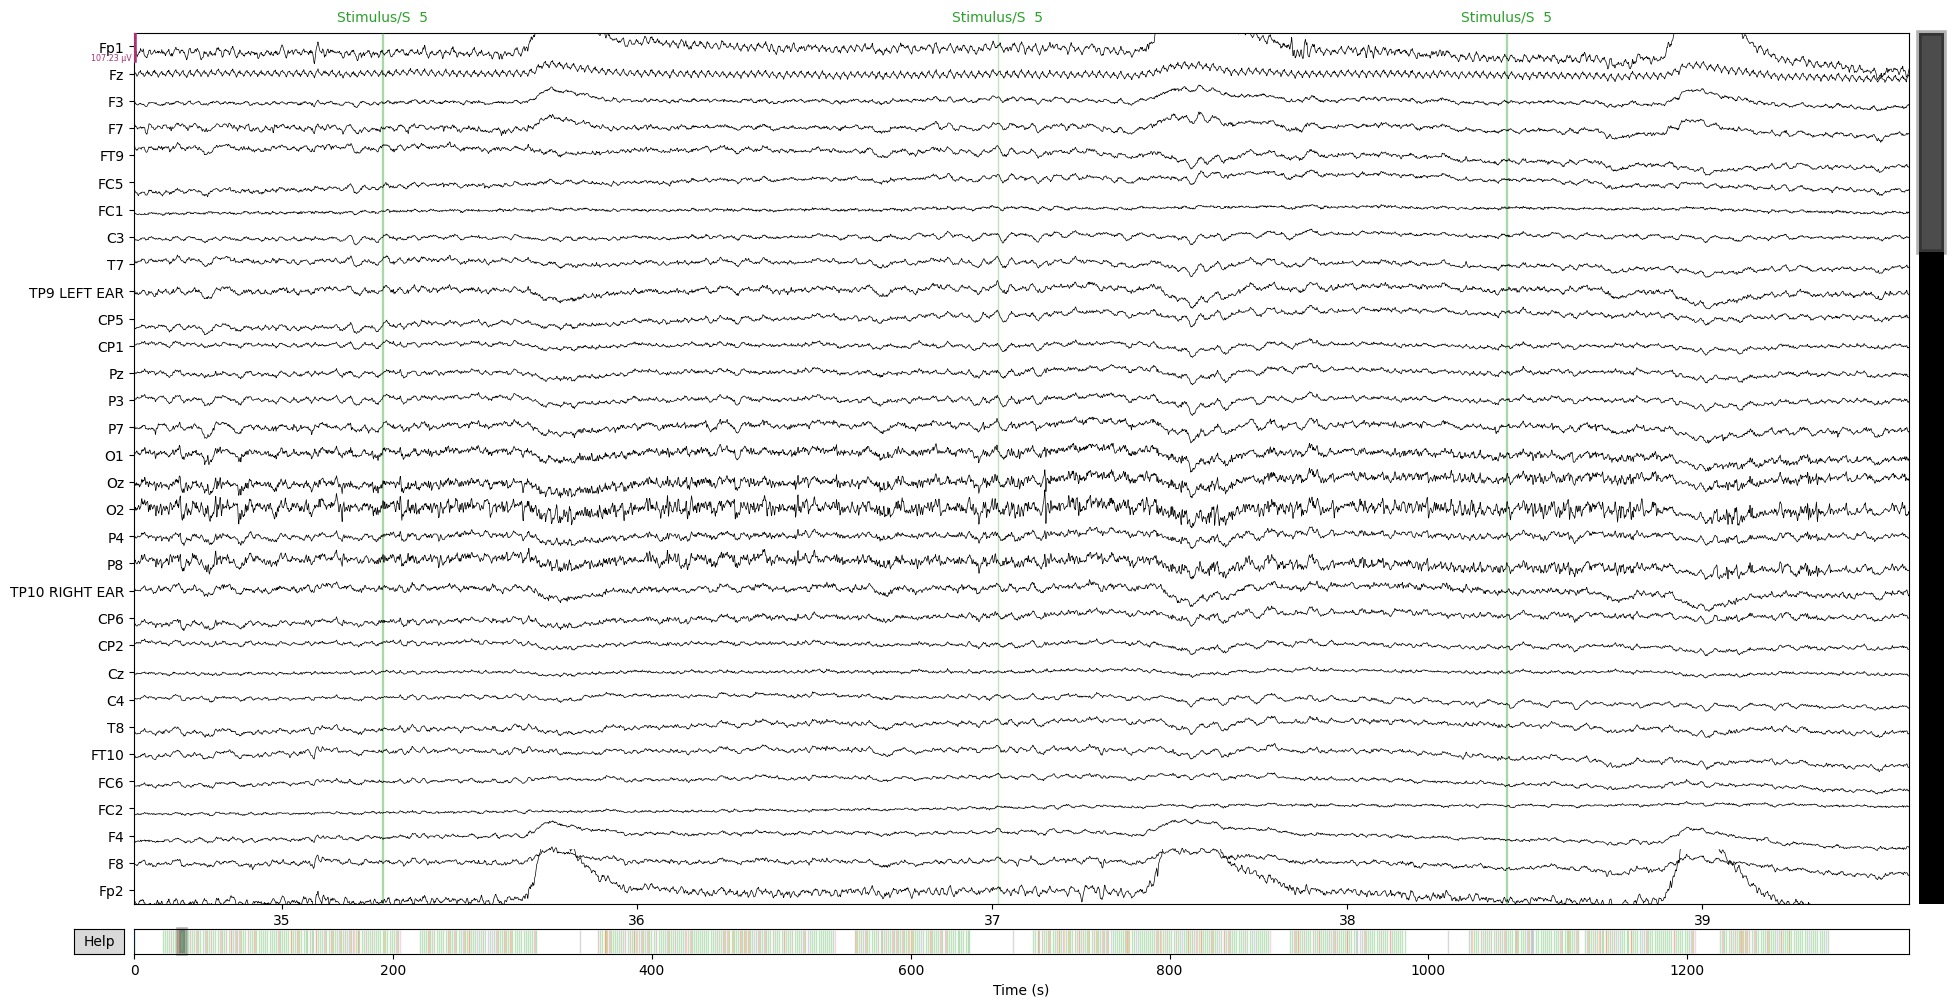

In [38]:
%matplotlib qt

raw.plot(
    n_channels=32,         # số kênh hiển thị
    scalings='auto',       # tự động scale theo biên độ
    duration=5,            # hiển thị 5 giây mỗi trang
    start=0,               # bắt đầu từ giây 0
    block=True             # mở interactive window (có thể zoom, lướt)
)


In [6]:
# Đặt lại tham chiếu trung bình
raw.set_eeg_reference('average', projection=True)


raw.filter(l_freq=0.1, h_freq=30)
raw.notch_filter(freqs=50)


ica = mne.preprocessing.ICA(n_components=20, random_state=42)
ica.fit(raw)

# Xem thành phần liên quan nháy mắt (sử dụng EOG)
ica.plot_components()
ica.plot_sources(raw)

# Loại bỏ component nháy mắt (ví dụ: 0, 1)
ica.exclude = [0, 1]
raw_ica = ica.apply(raw.copy())


events, event_id = mne.events_from_annotations(raw_ica)
print(event_id)


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 33001 samples (33.001 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

RuntimeError: No digitization points found.

In [ ]:
event_dict = {'Standard': event_id['S  5'],
              'Target': event_id['S  6'],
              'Deviant': event_id['S  7']}


epochs = mne.Epochs(
    raw_ica,
    events=events,
    event_id=event_dict,
    tmin=-0.2,
    tmax=0.8,
    baseline=(-0.2, 0),
    reject_by_annotation=True,
    preload=True
)



epochs = epochs.drop_bad(reject=dict(eeg=100e-6))  # loại epoch > ±100 µV


evoked_standard = epochs['Standard'].average()
evoked_target = epochs['Target'].average()
evoked_deviant = epochs['Deviant'].average()

%matplotlib qt

mne.viz.plot_compare_evokeds({
    'Standard': evoked_standard,
    'Target': evoked_target,
    'Deviant': evoked_deviant
}, picks='Pz')



In [ ]:
raw.info['ch_names']

In [20]:
fif_path = r"E:\UNIVERSITY\neurouScience\btl-EEG\preprocess\data\preprocessed\sub-01_task-oddball_preprocessed-raw.fif"
cleaned = mne.io.read_raw_fif(fif_path, preload=True)

Opening raw data file E:\UNIVERSITY\neurouScience\btl-EEG\preprocess\data\preprocessed\sub-01_task-oddball_preprocessed-raw.fif...
Isotrak not found
    Range : 0 ... 1371319 =      0.000 ...  1371.319 secs
Ready.
Reading 0 ... 1371319  =      0.000 ...  1371.319 secs...


Channels marked as bad:
none


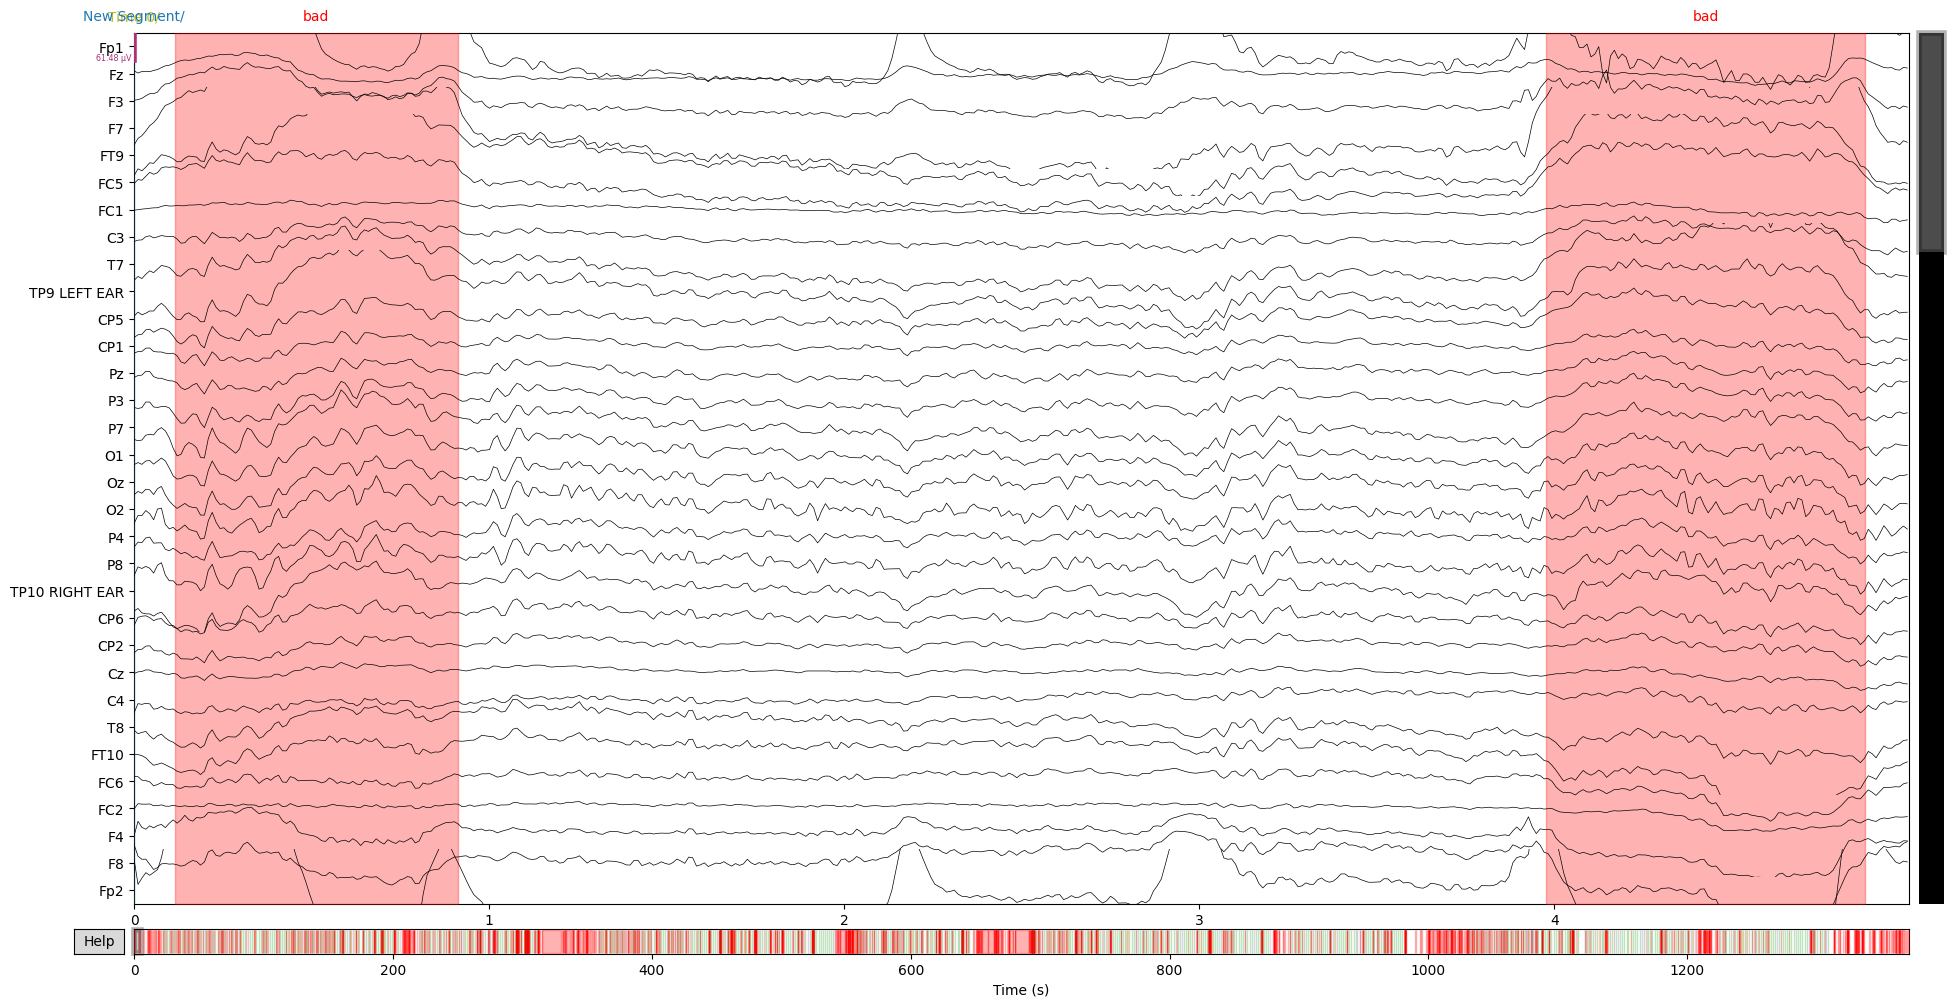

In [27]:
%matplotlib qt

cleaned.plot(
    n_channels=32,         # số kênh hiển thị
    scalings='auto',       # tự động scale theo biên độ
    duration=5,            # hiển thị 5 giây mỗi trang
    start=0,               # bắt đầu từ giây 0
    block=True             # mở interactive window (có thể zoom, lướt)
)


In [22]:
fif_path2 = r"E:\UNIVERSITY\neurouScience\btl-EEG\preprocess\data\preprocessed_mne-old\sub-01\sub-01_task-oddball_eeg_preproc_raw.fif"
cleaned2 = mne.io.read_raw_fif(fif_path2, preload=True)

Opening raw data file E:\UNIVERSITY\neurouScience\btl-EEG\preprocess\data\preprocessed_mne-old\sub-01\sub-01_task-oddball_eeg_preproc_raw.fif...
Isotrak not found
    Range : 0 ... 342829 =      0.000 ...  1371.316 secs
Ready.
Reading 0 ... 342829  =      0.000 ...  1371.316 secs...


Channels marked as bad:
none


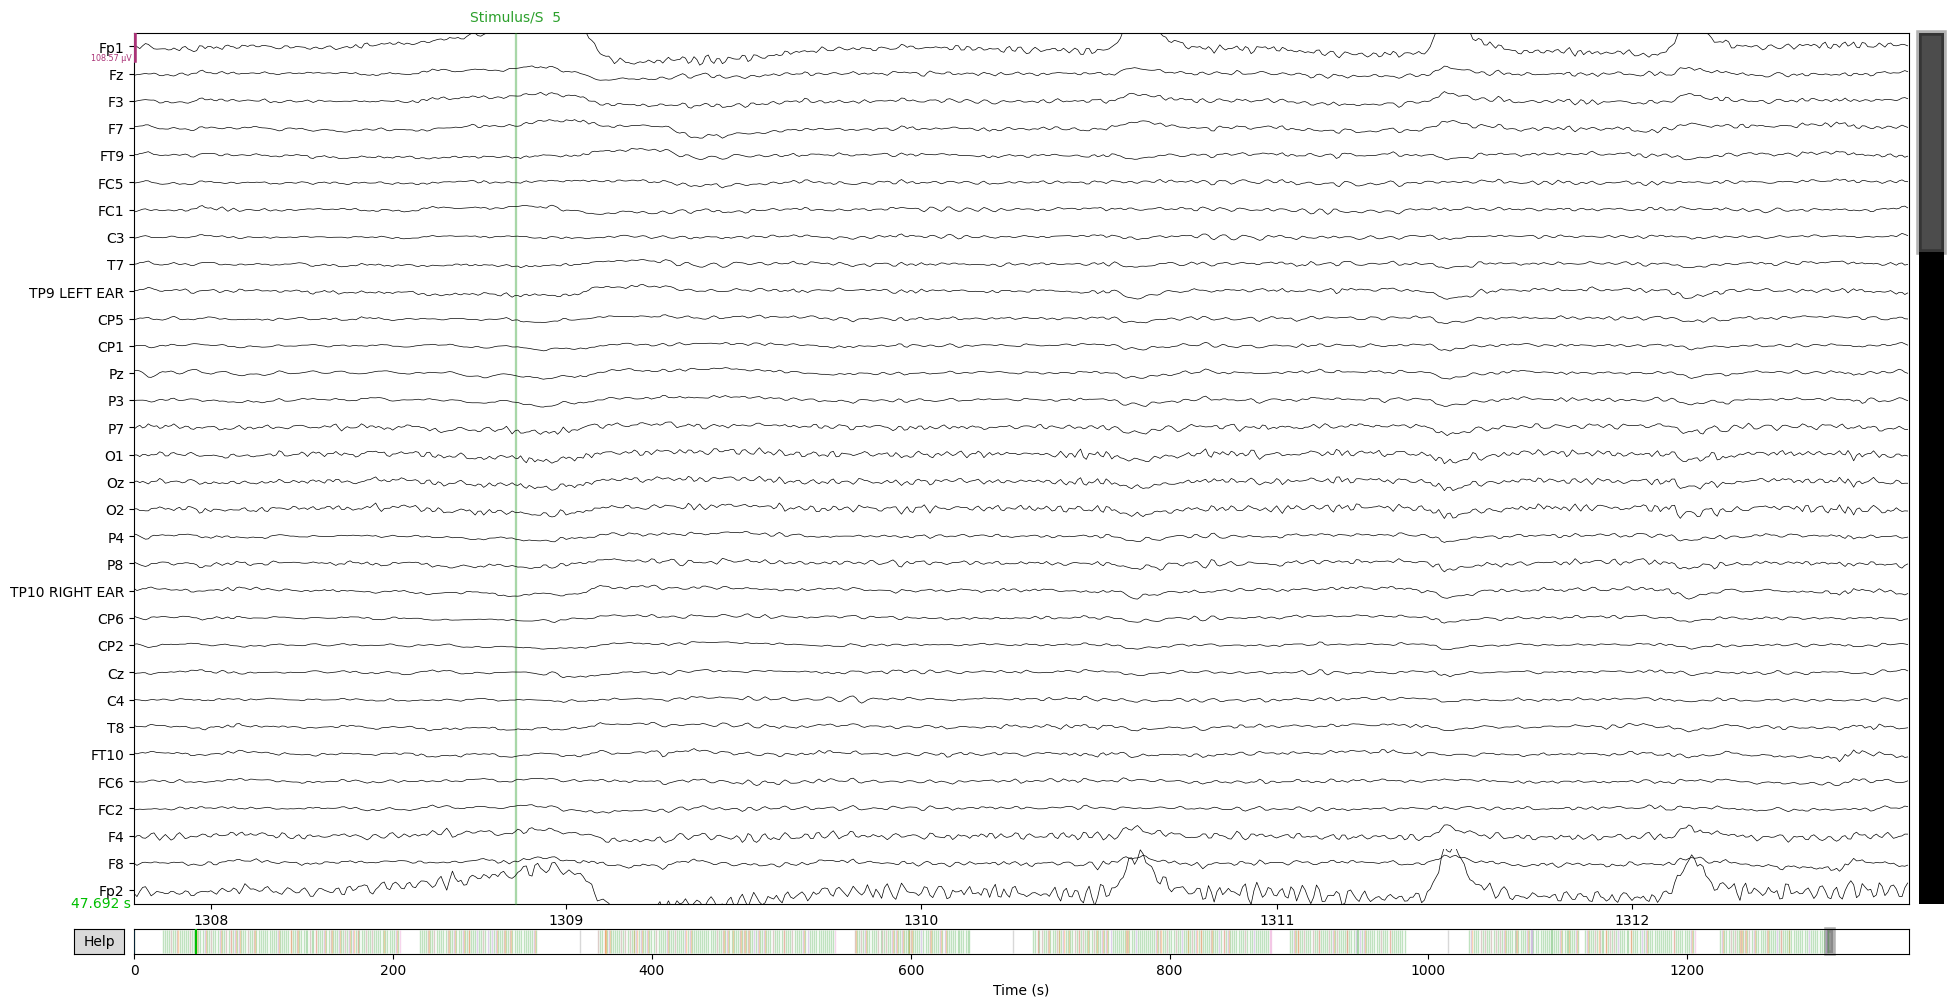

In [25]:
%matplotlib qt

cleaned2.plot(
    n_channels=32,         # số kênh hiển thị
    scalings='auto',       # tự động scale theo biên độ
    duration=5,            # hiển thị 5 giây mỗi trang
    start=0,               # bắt đầu từ giây 0
    block=True             # mở interactive window (có thể zoom, lướt)
)

## TEST -> KHÔNG CHỌN

In [ ]:
# da co bien raw



In [ ]:
# 1. Thiết lập tham chiếu lại (Re-referencing)

raw.set_eeg_reference('average', projection=True)  # hoặc 'REST' nếu cần

In [ ]:
# 2. Lọc tần số (Bandpass filtering)

raw.filter(l_freq=0.1, h_freq=30.0, fir_design='firwin')

In [ ]:
# 3. Loại bỏ nhiễu điện lưới (Notch filtering)

raw.notch_filter(freqs=50, fir_design='firwin')

In [ ]:
# 4. Áp dụng tham chiếu & loại kênh xấu (nếu có)

raw.apply_proj()  # Áp dụng average reference projection
# Nếu bạn biết kênh nào bị nhiễu (qua visual inspection), loại bỏ:
# raw.drop_channels(['bad_channel'])

In [ ]:
# 5. Phân đoạn dữ liệu theo sự kiện (Epoching)

from mne import events_from_annotations

events, event_id = events_from_annotations(raw)

# Chọn các sự kiện liên quan đến stimulus:
event_id_use = {
    'standard': event_id["Stimulus/S  5"],
    'deviant': event_id["Stimulus/S  7"],
    'target': event_id["Stimulus/S  6"]
}

tmin, tmax = -0.2, 0.8  # baseline + ERP window
epochs = mne.Epochs(
    raw, events, event_id_use,
    tmin=tmin, tmax=tmax,
    baseline=(None, 0),  # baseline = [-200, 0] ms
    preload=True,
    reject=dict(eeg=100e-6),  # loại epochs có biên độ >100 µV (nhiễu)
    reject_by_annotation=True
)

In [61]:
# 6. (Tùy chọn) Loại nhiễu mắt & vận động bằng ICA


from mne.preprocessing import ICA

ica = ICA(n_components=20, random_state=97)
ica.fit(epochs)

# Tự động hoặc thủ công loại thành phần liên quan EOG/EMG
# Ví dụ: ica.exclude = [0, 1] nếu đã xác định
epochs_clean = ica.apply(epochs.copy())

Fitting ICA to data using 127 channels (please be patient, this may take a while)
    Applying projection operator with 1 vector (pre-whitener computation)


C:\Users\LINH\AppData\Local\Temp\ipykernel_18692\1707221595.py:7: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(epochs)


    Applying projection operator with 1 vector (pre-whitener application)
Selecting by number: 20 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 4.3s.
Applying ICA to Epochs instance
    Applying projection operator with 1 vector (pre-whitener application)
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 127 PCA components


C:\Users\LINH\AppData\Local\Temp\ipykernel_18692\1707221595.py:11: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  epochs_clean = ica.apply(epochs.copy())


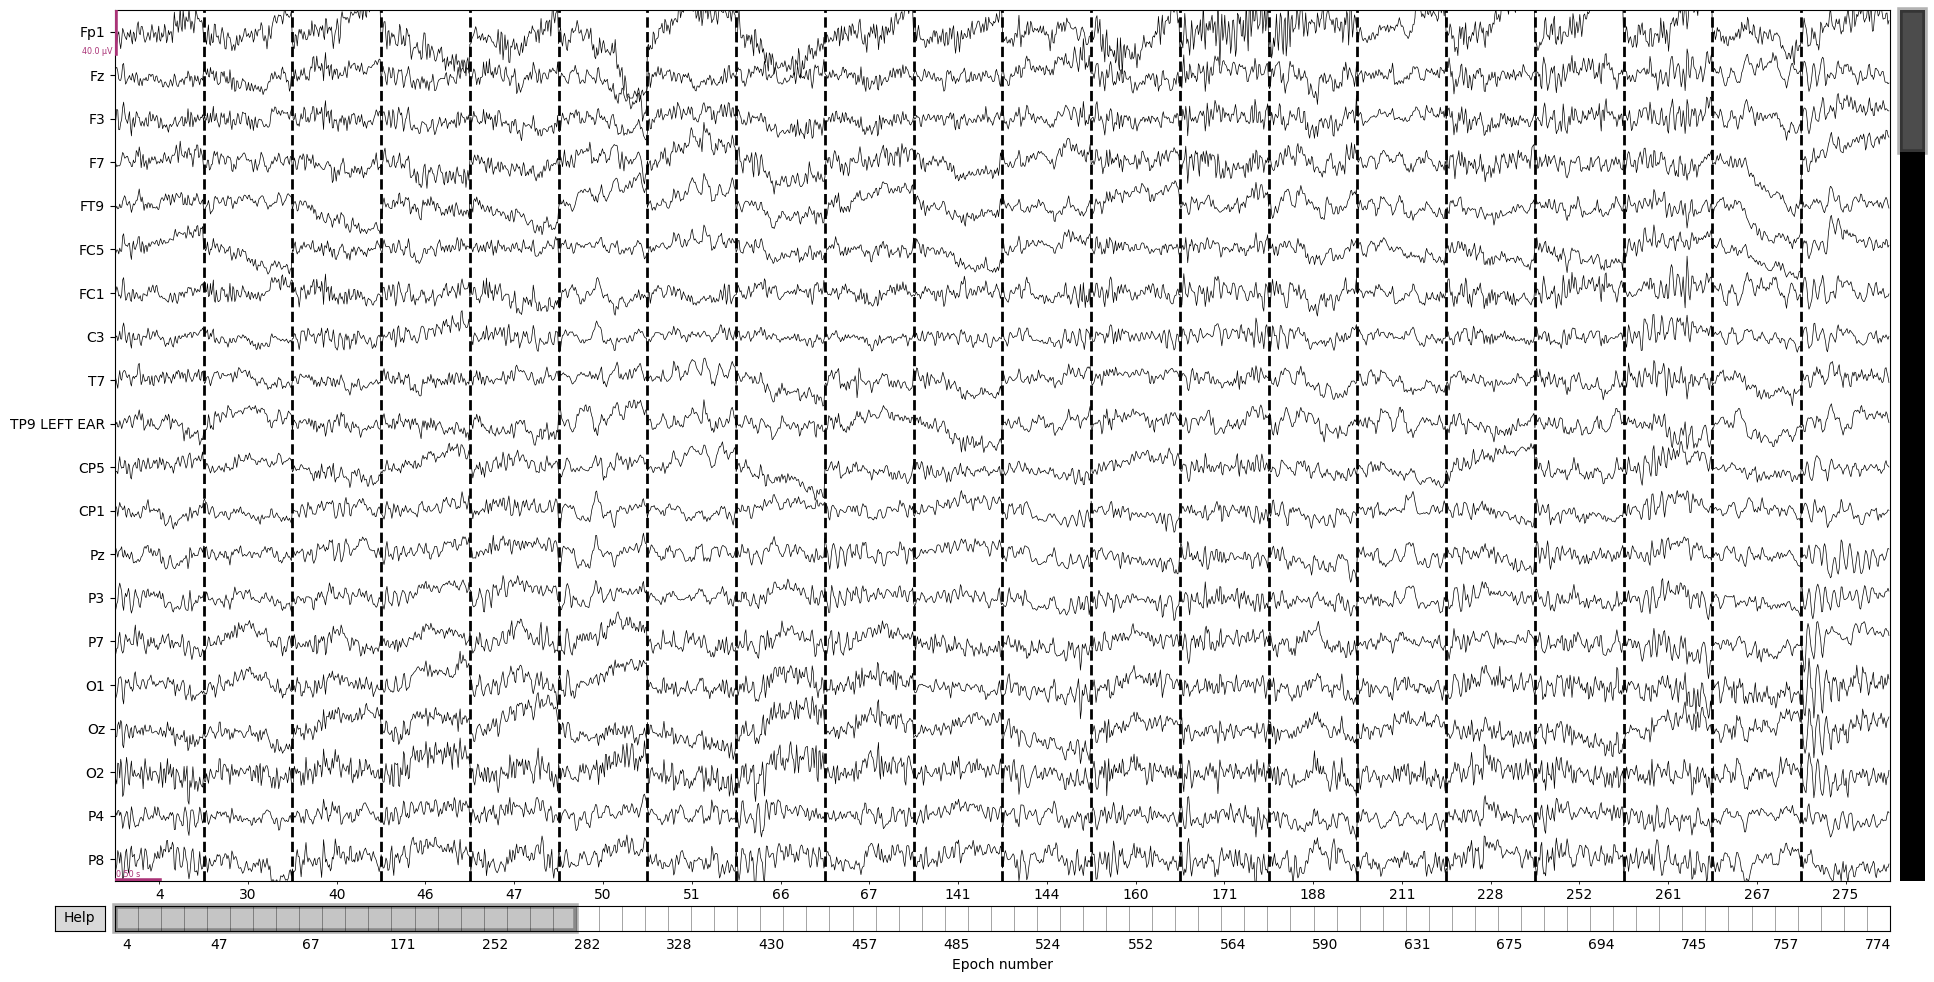

Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
['CP2', 'C4', 'P2', 'CP4']


In [ ]:
%matplotlib qt

epochs_clean.plot()

In [64]:
vhdf_path = r"E:\UNIVERSITY\neurouScience\btl-EEG\preprocess\data\original\sub-01\sub-01_task-oddball_eeg.vhdr"
raw = mne.io.read_raw_brainvision(vhdr_path, preload=True)

montage = mne.channels.read_custom_montage(electrode_pos_file)
raw.set_montage(montage, on_missing='warn')

Extracting parameters from data/original\sub-01\sub-01_task-oddball_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 1371319  =      0.000 ...  1371.319 secs...


NameError: name 'electrode_pos_file' is not defined

In [63]:
# Tổng kết pipeline cuối cùng (tự động, không cần can thiệp thủ công)

import mne
from mne.preprocessing import ICA, find_bad_channels_maxwell
from autoreject import AutoReject

# 1. Load data
vhdf_path = r"E:\UNIVERSITY\neurouScience\btl-EEG\preprocess\data\original\sub-01\sub-01_task-oddball_eeg.vhdr"
raw = mne.io.read_raw_brainvision(vhdr_path, preload=True)

# 2. (Tùy chọn) Set montage nếu có file .sfp/.elp
# montage = mne.channels.read_custom_montage(pos_file)
# raw.set_montage(montage)

# 3. Tìm và nội suy kênh nhiễu
raw.info['bads'] = []
auto_bads, _ = find_bad_channels_maxwell(raw, verbose=False)
raw.info['bads'] = auto_bads
raw.interpolate_bads(reset_bads=True)

# 4. Re-reference + lọc
raw.set_eeg_reference('average', projection=True)
raw.filter(0.1, 30.0)
raw.notch_filter(50)

# 5. Áp dụng tham chiếu
raw.apply_proj()

# 6. Tạo epochs
events, event_id = mne.events_from_annotations(raw)
event_id_use = {'standard': event_id['S  5'],
                'deviant': event_id['S  7'],
                'target': event_id['S  6']}
epochs = mne.Epochs(raw, events, event_id_use,
                    tmin=-0.2, tmax=0.8,
                    baseline=(None, 0),
                    preload=True,
                    reject_by_annotation=True)

# 7. Tự động loại nhiễu mắt bằng ICA
ica = ICA(n_components=0.99, random_state=42)
ica.fit(epochs)
eog_inds, _ = ica.find_bads_eog(epochs, ch_name=['Fp1', 'Fp2', 'AF7', 'AF8'])
ica.exclude = eog_inds
epochs_clean = ica.apply(epochs.copy())

# 8. Autoreject để loại epochs nhiễu còn sót
ar = AutoReject(random_state=42, verbose=False)
epochs_final, _ = ar.fit_transform(epochs_clean, return_log=True)

# 9. (Tùy chọn) Resample
epochs_final.resample(250)

Extracting parameters from data/original\sub-01\sub-01_task-oddball_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 1371319  =      0.000 ...  1371.319 secs...


ValueError: No channels match the selection.

## CHỌN CÁI NÀY: các bước preprocess: 



1. lọc lấy dữ liệu về dải từ 0.5 Hz đến 30 Hz
2. bước ICA 
3. loại bỏ biên độ theo ngưỡng: lấy ngước là +/- 100 microV 



ngoài ra ban đầu có 127 kênh, sau xử lí loại đi gần 30 kênh và chỉ còn khoảng 100 kênh hữu ích

In [ ]:
# cell 0 -> SỬA ĐƯỜNG DẪN 

# Import các thư viện cần thiết
import mne
import numpy as np
import matplotlib.pyplot as plt

# Tải file .vhdr của bạn
# (Hãy đảm bảo bạn đã có biến vhdr_path trỏ đúng đến file)
vhdr_path = r"E:\UNIVERSITY\neurouScience\btl-EEG\preprocess\data\original\sub-01\sub-01_task-oddball_eeg.vhdr"
raw = mne.io.read_raw_brainvision(vhdr_path, preload=True)


# In thông tin ban đầu
print("\nThông tin dữ liệu ban đầu:")
print(raw)
print(f"Tổng số kênh ban đầu: {len(raw.ch_names)}")

Extracting parameters from E:\UNIVERSITY\neurouScience\btl-EEG\preprocess\data\original\sub-01\sub-01_task-oddball_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 1371319  =      0.000 ...  1371.319 secs...

Thông tin dữ liệu ban đầu:
<RawBrainVision | sub-01_task-oddball_eeg.eeg, 127 x 1371320 (1371.3 s), ~1.30 GiB, data loaded>
Tổng số kênh ban đầu: 127


In [ ]:


# cell 1 -> KHÔNG CẦN SỬA 



# -----------------------------------------------------------------
# BẮT ĐẦU SỬA LỖI TỪ ĐÂY
# -----------------------------------------------------------------

# 1. Kênh tham chiếu (Reference) để loại bỏ
ref_channels = ['TP9 LEFT EAR', 'TP10 RIGHT EAR']

# 2. Kênh "rìa" (Edge/Muscle) để loại bỏ
edge_channels = [
    # Nhóm 1: Vùng Thái dương / Hàm / Má
    'FT9', 'FT10', 'F9', 'F10', 'FFT9h', 'FFT10h', 
    'FTT9h', 'FTT10h', 'TTP7h', 'TTP8h', 'TPP9h', 'TPP10h',
    # Nhóm 2: Vùng Chẩm / Cổ
    'P9', 'P10', 'PO9', 'PO10', 'O9', 'O10', 
    'POO9h', 'POO10h'
]

# 3. Kênh EOG (Mắt) - Sẽ giữ lại TẠM THỜI cho ICA
eog_channels = ['AFp1', 'AFp2']

# Tổng hợp các kênh *dự kiến* loại bỏ
channels_to_drop_planned = ref_channels + edge_channels

# Tạo một bản sao để giữ dữ liệu gốc nếu cần
raw_cleaned_copy = raw.copy()

# --- PHẦN SỬA LỖI QUAN TRỌNG ---
# Kiểm tra xem kênh nào trong danh sách dự kiến thực sự tồn tại trong file raw
# Điều này thay thế cho 'on_error="ignore"'
existing_channels = raw_cleaned_copy.ch_names
final_channels_to_drop = [ch for ch in channels_to_drop_planned if ch in existing_channels]

# Thực hiện loại bỏ kênh (giờ đã an toàn)
raw_cleaned_copy.drop_channels(final_channels_to_drop)
# -------------------------------

print(f"\nĐã loại bỏ {len(final_channels_to_drop)} kênh (tham chiếu + rìa).")
print(f"Số kênh còn lại: {len(raw_cleaned_copy.ch_names)}")

# In danh sách các kênh EOG sẽ được dùng
# (Kiểm tra xem 2 kênh EOG có còn tồn tại không)
existing_eog = [ch for ch in eog_channels if ch in raw_cleaned_copy.ch_names]
print(f"\nSẽ sử dụng các kênh sau làm kênh EOG cho ICA: {existing_eog}")

# In các kênh bị loại bỏ để kiểm tra
print(f"\nDanh sách kênh đã loại bỏ: {final_channels_to_drop}")


Đã loại bỏ 22 kênh (tham chiếu + rìa).
Số kênh còn lại: 105

Sẽ sử dụng các kênh sau làm kênh EOG cho ICA: ['AFp1', 'AFp2']

Danh sách kênh đã loại bỏ: ['TP9 LEFT EAR', 'TP10 RIGHT EAR', 'FT9', 'FT10', 'F9', 'F10', 'FFT9h', 'FFT10h', 'FTT9h', 'FTT10h', 'TTP7h', 'TTP8h', 'TPP9h', 'TPP10h', 'P9', 'P10', 'PO9', 'PO10', 'O9', 'O10', 'POO9h', 'POO10h']


In [106]:
# --- CELL 2 (ĐÃ SỬA LỖI LẦN 2) ---

# Đặt kiểu (type) của kênh AFp1 và AFp2 thành 'eog'
try:
    raw_cleaned_copy.set_channel_types({'AFp1': 'eog', 'AFp2': 'eog'})
    print("Đã đặt kiểu kênh cho 'AFp1' và 'AFp2' thành 'eog'.")
except ValueError:
    print("Không tìm thấy kênh 'AFp1' hoặc 'AFp2' để đặt làm EOG.")

# -----------------------------------------------------------------
# Gán vị trí 3D (Montage 'standard_1005')
# SỬA LỖI: Xóa bỏ tham số 'on_error="warn"' vì MNE không hỗ trợ
# -----------------------------------------------------------------
print("Đang gán vị trí 3D (Montage 'standard_1005')...")
montage = mne.channels.make_standard_montage('standard_1005')

# MNE sẽ tự động cảnh báo (warn) nếu có kênh nào đó 
# trong raw_cleaned không có trong montage 'standard_1005'.
# Đây là hành vi mặc định, không cần 'on_error'.
raw_cleaned_copy.set_montage(montage) 

print("Đã gán xong montage.")
print(raw_cleaned_copy.info)

Đã đặt kiểu kênh cho 'AFp1' và 'AFp2' thành 'eog'.
Đang gán vị trí 3D (Montage 'standard_1005')...
Đã gán xong montage.
<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, FC5, FC1, C3, T7, CP5, CP1, Pz, P3, P7, O1, Oz, ...
 chs: 103 EEG, 2 EOG
 custom_ref_applied: False
 dig: 106 items (3 Cardinal, 103 EEG)
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: unspecified
 nchan: 105
 projs: []
 sfreq: 1000.0 Hz
>


C:\Users\LINH\AppData\Local\Temp\ipykernel_18692\969990993.py:20: RuntimeWarning: Not setting positions of 2 eog channels found in montage:
['AFp1', 'AFp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_cleaned_copy.set_montage(montage)


In [107]:
# cell 3

# 1. Lọc Notch 50Hz để loại bỏ nhiễu đường dây điện
# (Bạn có thể bỏ qua nếu chắc chắn dữ liệu không bị)
print("Đang lọc Notch 50 Hz...")
raw_cleaned_copy.notch_filter(freqs=50, fir_design='firwin')

# 2. Lọc thông dải (Band-pass) từ 0.5 Hz đến 30 Hz
print("Đang lọc thông dải 0.5 - 30 Hz...")
raw_cleaned_copy.filter(l_freq=0.5, h_freq=30, fir_design='firwin')

print("Hoàn thành Bước 1: Lọc tần số.")

Đang lọc Notch 50 Hz...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 6601 samples (6.601 s)

Đang lọc thông dải 0.5 - 30 Hz...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.5

In [108]:
# cell 4: buoc 2 phan 1

from mne.preprocessing import ICA

# Tạo một bản sao của dữ liệu chỉ để huấn luyện ICA
# Lọc bản sao này ở 1.0 Hz (theo khuyến cáo của MNE)
raw_for_ica_fit = raw_cleaned_copy.copy().filter(l_freq=1.0, h_freq=None)

# Khởi tạo mô hình ICA
# n_components=0.95: Giữ lại số lượng thành phần giải thích 95% phương sai
# method='fastica': Thuật toán phổ biến
# random_state=97: Để đảm bảo kết quả lặp lại được
ica = ICA(n_components=0.95, method='fastica', random_state=97, max_iter=800)

print("Đang huấn luyện (fit) mô hình ICA...")
# Fit ICA trên dữ liệu đã lọc 1Hz
ica.fit(raw_for_ica_fit)

print("Hoàn thành huấn luyện ICA.")
print(ica)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 3301 samples (3.301 s)

Đang huấn luyện (fit) mô hình ICA...
Fitting ICA to data using 103 channels (please be patient, this may take a while)
Selecting by explained variance: 7 components
Fitting ICA took 68.6s.
Hoàn thành huấn luyện ICA.
<ICA | raw data decomposition, method: fastica (fit in 29 iterations on 1371320 samples), 7 ICA components (103 PCA components available), channel types: eeg, no sources marked for exclusion>


In [ ]:
# NGHỊCH THÔI NHÁ

# # 1. Plot topography (bản đồ não) của các thành phần
# # Nhiễu mắt (EOG) thường có màu đỏ đậm ở vùng trán
# # Nhiễu tim (ECG) thường có dạng 2 cực (dipole) ở 2 bên thái dương
# print("Đang vẽ bản đồ thành phần (Component Topographies)...")
# # Thêm 'sensors=False' để tránh lỗi nếu vị trí kênh bị thiếu
# ica.plot_components(sensors=False)
# plt.show()

# # 2. Plot time series của các thành phần
# # Click vào tên component (ví dụ 'ICA001') để xem tín hiệu
# # Nhiễu mắt sẽ có dạng các xung nhọn (nháy mắt) rất rõ ràng
# # Nhiễu tim sẽ có dạng các xung nhịp đều đặn (QRS)
# print("Đang vẽ chuỗi thời gian của thành phần (Component Sources)...")
# # Lấy một đoạn ngắn để vẽ cho nhanh
# ica.plot_sources(raw_cleaned_copy, start=0, stop=10)
# plt.show()

Đang vẽ bản đồ thành phần (Component Topographies)...
Đang vẽ chuỗi thời gian của thành phần (Component Sources)...
Creating RawArray with float64 data, n_channels=7, n_times=1371320
    Range : 0 ... 1371319 =      0.000 ...  1371.319 secs
Ready.


In [109]:
# cell 5

# Tự động tìm các thành phần (components) khớp với nhiễu EOG
# (Phần này đã chạy tốt)
print("Đang tự động tìm thành phần nhiễu EOG...")
eog_indices, eog_scores = ica.find_bads_eog(raw_cleaned_copy, ch_name=eog_channels)

# -----------------------------------------------------------------
# SỬA LỖI CHO PHẦN TÌM ECG TỰ ĐỘNG
# -----------------------------------------------------------------
print("Đang tự động tìm thành phần nhiễu ECG (từ dữ liệu EEG)...")

ecg_indices = []  # Khởi tạo là list rỗng

try:
    # 1. Tạo các "epochs" (đoạn) tập trung vào nhịp tim.
    # Hàm này sẽ tự động tìm các đỉnh QRS từ dữ liệu EEG.
    # (Chúng ta chỉ dùng bản sao đã lọc 1Hz để tìm cho nhanh và chính xác)
    ecg_epochs = mne.preprocessing.create_ecg_epochs(
        raw_cleaned_copy.copy().filter(l_freq=1.0, h_freq=40.0), 
        tmin=-0.5, 
        tmax=0.5
    )
    
    # 2. Dùng các epochs tim này để tìm thành phần ICA tương quan
    # Chúng ta truyền `ecg_epochs` vào làm 'inst'
    ecg_indices, ecg_scores = ica.find_bads_ecg(
        ecg_epochs, 
        method='correlation'
    )
    
except RuntimeError as e:
    # Lỗi này xảy ra nếu 'create_ecg_epochs' không tìm thấy nhịp tim
    print(f"\n*** CẢNH BÁO: Không thể tự động tìm thấy thành phần ECG. Lỗi: {e}")
    print("Điều này thường xảy ra nếu tín hiệu tim quá yếu trong các kênh EEG.")
    print("Vui lòng TỰ KIỂM TRA bằng mắt các thành phần trong plot bên dưới.")
    ecg_indices = [] # Đảm bảo là list rỗng
except Exception as e:
    # Bắt các lỗi khác (nếu có)
    print(f"\n*** CẢNH BÁO: Đã xảy ra lỗi không mong muốn khi tìm ECG: {e}")
    print("Vui lòng TỰ KIỂM TRA bằng mắt các thành phần trong plot bên dưới.")
    ecg_indices = []
# -----------------------------------------------------------------
# KẾT THÚC SỬA LỖI
# -----------------------------------------------------------------

# Gộp các chỉ số (indices) của thành phần nhiễu tìm được
ica.exclude = eog_indices + ecg_indices

print(f"\nCác thành phần EOG (mắt) được tìm thấy: {eog_indices}")
print(f"Các thành phần ECG (tim) được tìm thấy: {ecg_indices}")
print(f"==> Tổng cộng các thành phần sẽ bị LOẠI BỎ: {ica.exclude}")

# --- Trực quan hóa (QUAN TRỌNG) ---
# Bạn NÊN tự mình kiểm tra lại các thành phần này
# Chạy cell này sẽ mở các cửa sổ tương tác:

# 1. Plot topography (bản đồ não) của các thành phần
# Nhiễu mắt (EOG) thường có màu đỏ đậm ở vùng trán
# Nhiễu tim (ECG) thường có dạng 2 cực (dipole) ở 2 bên thái dương
print("Đang vẽ bản đồ thành phần (Component Topographies)...")
# Thêm 'sensors=False' để tránh lỗi nếu vị trí kênh bị thiếu
ica.plot_components(sensors=False)
plt.show()

# 2. Plot time series của các thành phần
# Click vào tên component (ví dụ 'ICA001') để xem tín hiệu
# Nhiễu mắt sẽ có dạng các xung nhọn (nháy mắt) rất rõ ràng
# Nhiễu tim sẽ có dạng các xung nhịp đều đặn (QRS)
print("Đang vẽ chuỗi thời gian của thành phần (Component Sources)...")
# Lấy một đoạn ngắn để vẽ cho nhanh
ica.plot_sources(raw_cleaned_copy, start=0, stop=10)
plt.show()

# ==> NHẮC LẠI: Nếu bạn không đồng ý với lựa chọn tự động (hoặc nếu
# 'ecg_indices' bị rỗng), bạn hãy nhìn vào 2 plot trên để TỰ XÁC ĐỊNH
# các thành phần nhiễu (ví dụ, bạn thấy component 005 là tim).
# Sau đó, gán lại bằng tay vào danh sách 'ica.exclude':
# 
# Bỏ comment dòng dưới và sửa nếu cần:
ica.exclude = [0] # Ví dụ: Ghi đè, loại bỏ 0, 1 (mắt) và 5 (tim)
print(f"Đã cập nhật thủ công danh sách loại bỏ: {ica.exclude}")

Đang tự động tìm thành phần nhiễu EOG...
Using EOG channels: AFp1, AFp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwid

In [110]:
# cell 6

print("Đang áp dụng ICA để loại bỏ nhiễu...")
# Đây là lúc dữ liệu thực sự được làm sạch
ica.apply(raw_cleaned_copy)

print("Đã loại bỏ thành công các thành phần nhiễu khỏi tín hiệu.")

# Cuối cùng, loại bỏ 2 kênh EOG chuyên dụng vì chúng ta không cần chúng nữa
raw_cleaned_copy.drop_channels(eog_channels)
print(f"Đã loại bỏ 2 kênh EOG ({eog_channels}).")
print(f"Số kênh EEG sạch cuối cùng: {len(raw_cleaned_copy.ch_names)}")

Đang áp dụng ICA để loại bỏ nhiễu...
Applying ICA to Raw instance
    Transforming to ICA space (7 components)
    Zeroing out 1 ICA component
    Projecting back using 103 PCA components
Đã loại bỏ thành công các thành phần nhiễu khỏi tín hiệu.
Đã loại bỏ 2 kênh EOG (['AFp1', 'AFp2']).
Số kênh EEG sạch cuối cùng: 103


In [115]:
# raw_cleaned_copy.plot()
back_up = raw_cleaned_copy.copy()

In [ ]:
# --- CELL 7 (VIẾT LẠI - SỬ DỤNG ANNOTATIONS) ---

# 1. TẠO BẢN ĐỒ SỰ KIỆN (Event ID Map)
# Chúng ta "bảo" cho MNE biết phải tìm annotation (chú thích) nào
# và gán cho nó ID số nguyên (integer) nào.
#
# Dựa trên file mô tả và log 'Mk' của bạn, tên sự kiện có 2 dấu cách: 'S  5'
# (Nếu code này lỗi, hãy thử lại với 1 dấu cách: 'S 5')
#
event_id_map = {
    'Stimulus/S  5': 5,   # Standard
    'Stimulus/S  6': 6,   # Target
    'Stimulus/S  7': 7    # Distractor
}
print(f"Sẽ trích xuất các sự kiện (annotations) sau: {event_id_map}")

# 2. TRÍCH XUẤT SỰ KIỆN TỪ ANNOTATIONS
# Đây là hàm chính xác thay thế cho 'mne.find_events'
# Nó sẽ đọc 'raw_cleaned.annotations' để tìm các marker
try:
    events, _ = mne.events_from_annotations(back_up, event_id=event_id_map)
except ValueError:
    print("\n--- LỖI ---")
    print("Không tìm thấy sự kiện nào khớp với bản đồ 'event_id_map'.")
    print("Có thể do MNE đọc marker của bạn với tên khác (ví dụ 'Stimulus/S  5').")
    print("Hãy chạy cell code ở dưới để kiểm tra...")
    raise

# In ra 5 sự kiện đầu tiên để kiểm tra
print(f"\nTìm thấy {len(events)} sự kiện. 5 sự kiện đầu tiên (mẫu, 0, ID):")
print(events[:5])

# 3. ĐỊNH NGHĨA ID CHO EPOCHS (để đặt tên cho dễ)
# Bây giờ chúng ta dùng các ID số (5, 6, 7) mà ta đã gán ở trên
epoch_event_id = {
    'Standard': 5,
    'Target': 6,
    'Distractor': 7
}
print(f"\nSử dụng Epoch IDs: {epoch_event_id}")

# 4. Định nghĩa thời gian của Epoch
tmin, tmax = -0.2, 0.8 # -200ms đến +800ms

# 5. Tạo Epochs (từ dữ liệu THẬT)
print("Đang tạo epochs...")
epochs = mne.Epochs(back_up, 
                    events, 
                    epoch_event_id, 
                    tmin, 
                    tmax,
                    baseline=(-0.2, 0), # Áp dụng baseline correction
                    reject=None, 
                    preload=True)

print(f"Đã tạo được {len(epochs)} epochs ban đầu cho các điều kiện quan tâm.")

# -----------------------------------------------------------------
# 6. THỰC HIỆN BƯỚC 3: Loại bỏ theo ngưỡng tuyệt đối +/- 100 µV
# -----------------------------------------------------------------
threshold_uv = 100.0
threshold = threshold_uv * 1e-6 # Chuyển sang Volts

print(f"\n--- Bước 3: Đang loại bỏ Epochs theo ngưỡng +/- {threshold_uv} µV ---")
epochs_clean = epochs.copy().drop_bad(reject={'eeg': threshold})

# In ra kết quả
print(f"Số epochs ban đầu: {len(epochs)}")
print(f"Số epochs SẠCH còn lại: {len(epochs_clean)}")
print(f"Số epochs bị loại bỏ: {len(epochs) - len(epochs_clean)}")

# In chi tiết số lượng bị loại bỏ cho từng điều kiện
print("\nChi tiết loại bỏ:")
for condition in epoch_event_id.keys():
    try:
        n_start = len(epochs[condition])
        n_clean = len(epochs_clean[condition])
        n_dropped = n_start - n_clean
        print(f"  - {condition}: Bắt đầu {n_start}, loại bỏ {n_dropped} -> còn {n_clean}")
    except KeyError:
        print(f"  - {condition}: Không tìm thấy epochs nào cho điều kiện này.")

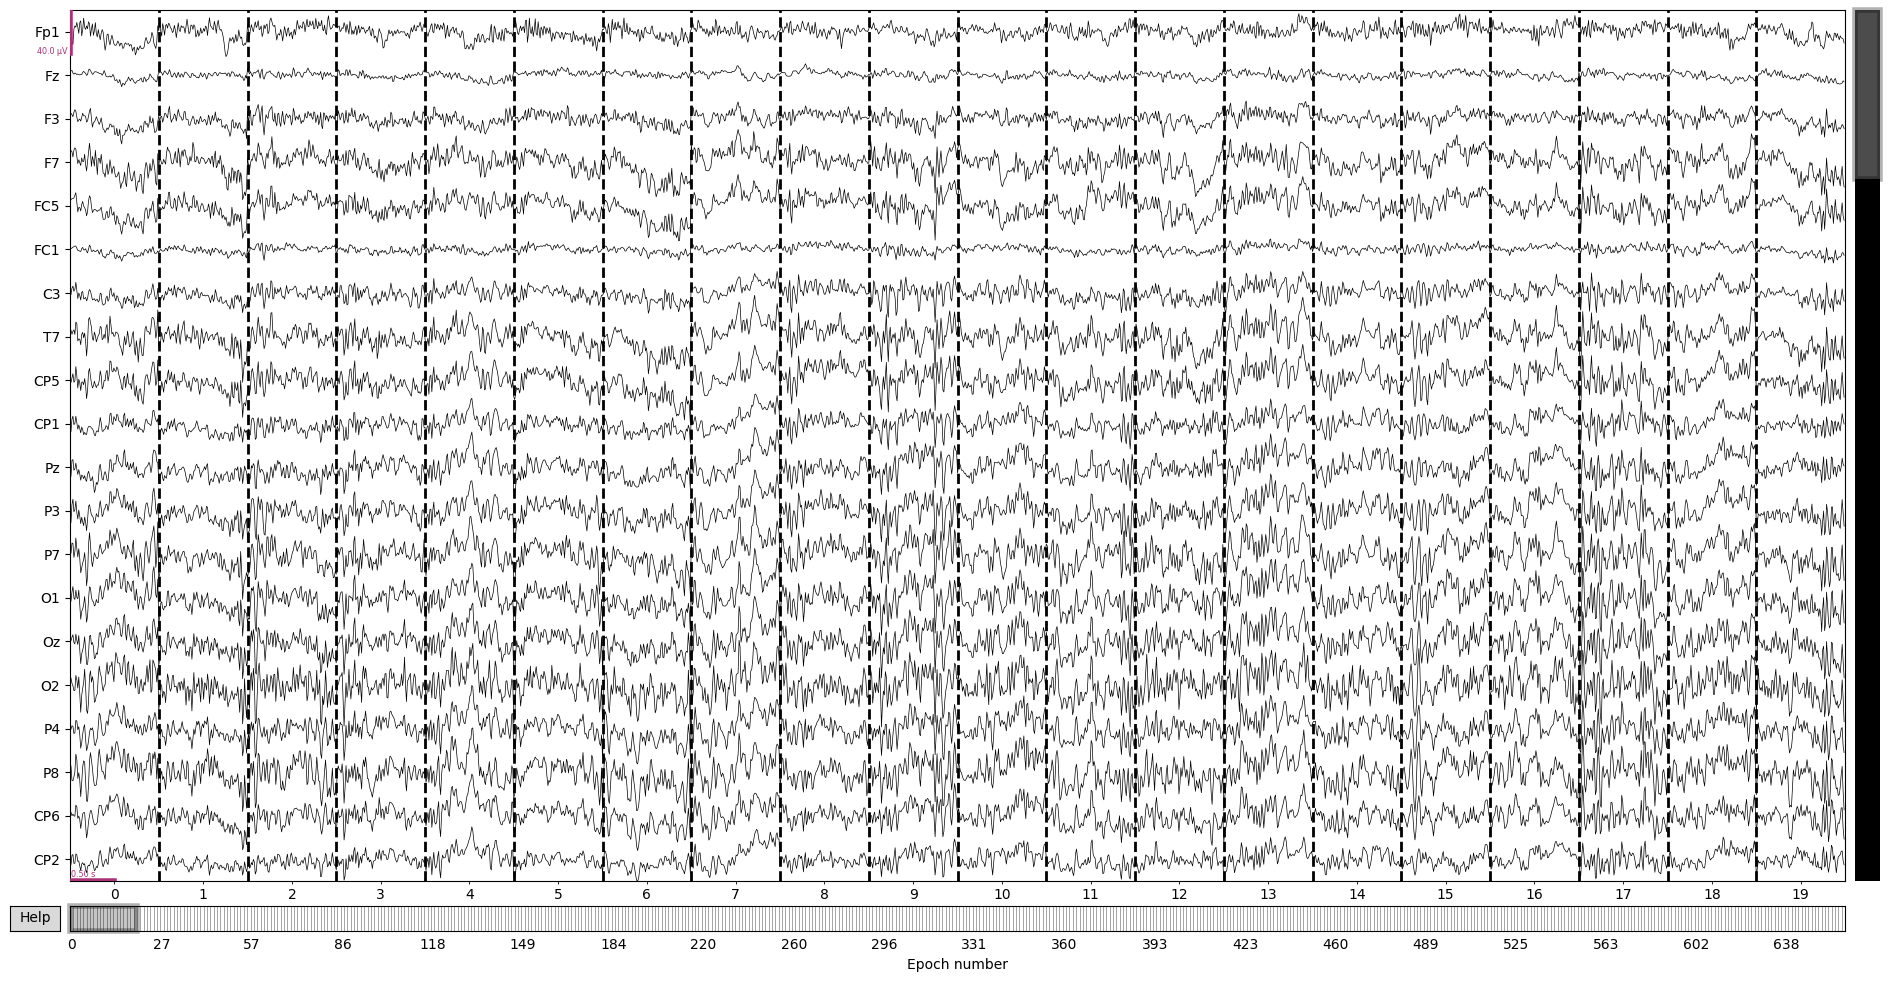

Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none


In [ ]:
epochs_clean.plot()

In [133]:
# --- CELL 8 (CẬP NHẬT) ---

# Tính trung bình (ERP) cho từng điều kiện
try:
    evoked_standard = epochs_clean['Standard'].average()
    evoked_target = epochs_clean['Target'].average()
    evoked_distractor = epochs_clean['Distractor'].average()
    
    # Tạo một dictionary để vẽ
    evokeds_to_plot = {
        'Standard (S 5)': evoked_standard,
        'Target (S 6)': evoked_target,
        'Distractor (S 7)': evoked_distractor
    }

    # Vẽ ERP tại kênh Pz (kênh P300 cổ điển)
    # Bạn cũng có thể dùng ['Pz', 'Cz', 'CPz']
    picks = ['Pz'] 
    
    print(f"\nĐang vẽ biểu đồ ERP tại kênh {picks}...")
    mne.viz.plot_compare_evokeds(
        evokeds_to_plot,
        picks=picks,
        title=f"ERP (Oddball Task) at channel {picks[0]} (Cleaned Data)"
    )
    plt.show()

except KeyError as e:
    print(f"\nLỗi khi tính trung bình: {e}")
    print("Điều này có thể xảy ra nếu tất cả epochs của một điều kiện đã bị loại bỏ.")
    print("Hãy kiểm tra kết quả của Cell 7.")
except Exception as e:
    print(f"Không thể vẽ biểu đồ: {e}")


Đang vẽ biểu đồ ERP tại kênh ['Pz']...


In [ ]:
# cell 9: lưu data

# Đặt tên file (đuôi -epo.fif là quy ước)
save_path_epochs = 'sub-01_cleaned.fif'

# Lưu đối tượng epochs_clean
# overwrite=True sẽ ghi đè nếu file đã tồn tại
epochs_clean.save(save_path_epochs, overwrite=True)

print(f"Đã lưu dữ liệu epochs sạch vào: {save_path_epochs}")



C:\Users\LINH\AppData\Local\Temp\ipykernel_18692\1470361210.py:8: RuntimeWarning: This filename (sub-01_cleaned.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_clean.save(save_path_epochs, overwrite=True)


Đã lưu dữ liệu epochs sạch vào: sub-01_cleaned.fif


In [ ]:
# cell 10: tải lại

# --- Cách tải lại sau này ---
# import mne
# epochs_loaded = mne.read_epochs(save_path_epochs)
# print(epochs_loaded.plot())

Reading e:\UNIVERSITY\neurouScience\btl-EEG\preprocess\sub-01_cleaned.fif ...


C:\Users\LINH\AppData\Local\Temp\ipykernel_18692\2721178688.py:5: RuntimeWarning: This filename (sub-01_cleaned.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_loaded = mne.read_epochs(save_path_epochs)


    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
531 matching events found
No baseline correction applied
0 projection items activated
Figure(1920x991)


Dropped 2 epochs: 0, 2
The following epochs were marked as bad and are dropped:
[0, 2]
Channels marked as bad:
none
